In [ ]:
!unzip /content/dataset-dental-floss.zip

In [2]:
import os
import cv2
import zipfile
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
# Caminho do dataset

dataset_dir = pathlib.Path('/content/ds/')

# Parâmetros das imagens

image_size = (128, 128)
batch_size = 64

In [5]:
# Dividir dataset

# Conjunto de Treino (75%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.25,  # 25% do dataset para validação e teste
    subset='training',
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale'
)

# Conjunto de Validação (15%) e Teste (10%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.25,
    subset='validation',
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale'
)

Found 4066 files belonging to 2 classes.
Using 3050 files for training.
Found 4066 files belonging to 2 classes.
Using 1016 files for validation.


In [6]:
# Normalizar as imagens

normalizacao = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalizacao(x), y))
val_ds = val_ds.map(lambda x, y: (normalizacao(x), y))

In [7]:
# Dividir validação e teste
# 'val_ds' tem 25% dos dados.
# 60% de 25% = 15% do total
# 40% de 25% = 10% do total

val_batches = tf.data.experimental.cardinality(val_ds)

test_ds = val_ds.take(tf.cast(tf.cast(val_batches, tf.float32) * 0.4, tf.int64))
val_ds = val_ds.skip(tf.cast(tf.cast(val_batches, tf.float32) * 0.4, tf.int64))

In [8]:
# Verificando os conjuntos

print(f"Número de lotes de treinamento: {tf.data.experimental.cardinality(train_ds)}")
print(f"Número de lotes de validação: {tf.data.experimental.cardinality(val_ds)}")
print(f"Número de lotes de teste: {tf.data.experimental.cardinality(test_ds)}")

Número de lotes de treinamento: 48
Número de lotes de validação: 10
Número de lotes de teste: 6


In [9]:
# Configuração para desempenho
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# Data Augmentation para o conjunto de treino
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),  # Inverte a imagem horizontalmente
    layers.RandomContrast(0.2)       # Variação de contraste
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [11]:
num_classes = 2

## 1. Modelo sem Dropout

In [12]:
model = keras.Sequential([
    # camada de entrada com o formato das suas imagens (128x128)
    layers.Input(shape=(128, 128, 1)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## 2. Modelo com Dropout

In [63]:
from tensorflow.keras import layers

In [128]:
model = keras.Sequential([
    layers.Input(shape=(128, 128, 1)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),

    # Adicionando uma camada de Dropout com taxa de 50%
    layers.Dropout(0.4),

    layers.Dense(num_classes)
])

# Treino

In [129]:
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,322 (12.60 MB)

 Trainable params: 3,304,322 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [130]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [131]:
epochs = 13

In [132]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

print("Treinamento concluído!")

Epoch 1/13
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.5419 - loss: 0.7059 - val_accuracy: 0.6598 - val_loss: 0.5970
Epoch 2/13
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6451 - loss: 0.6214 - val_accuracy: 0.6646 - val_loss: 0.5721
Epoch 3/13
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6584 - loss: 0.6015 - val_accuracy: 0.7057 - val_loss: 0.5390
Epoch 4/13
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6768 - loss: 0.5865 - val_accuracy: 0.7326 - val_loss: 0.5178
Epoch 5/13
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7118 - loss: 0.5547 - val_accuracy: 0.7737 - val_loss: 0.4858
Epoch 6/13
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7348 - loss: 0.5259 - val_accuracy: 0.7927 - val_loss: 0.4537
Epoch 7/13
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7403 - loss: 0.5106 - val_accuracy: 0.7943 - val_loss: 0.4396
Epoch 8/13
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7733 - loss: 0.4695 - val_accuracy: 0.7959 - v

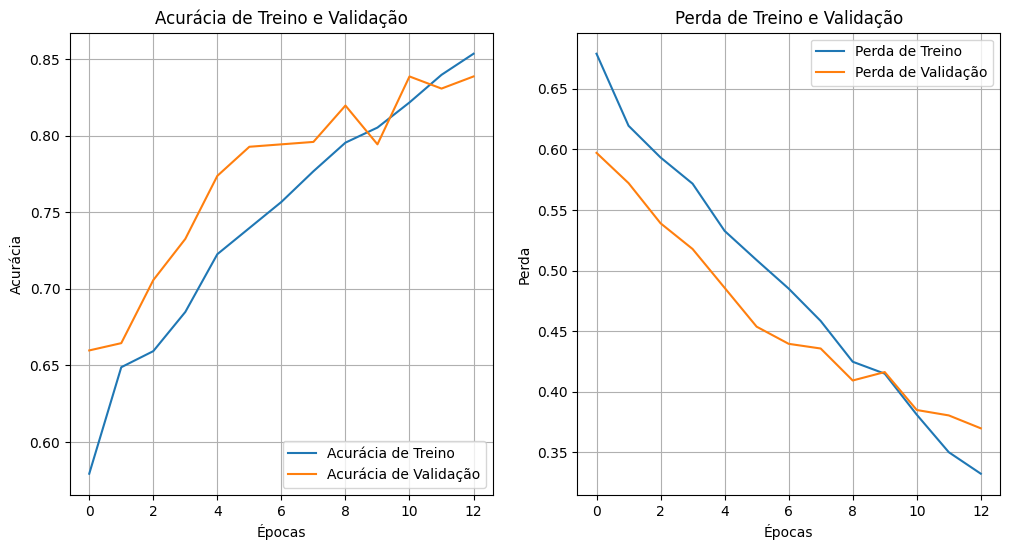


--- Resultados Finais ---
Acurácia final de Treino: 0.8534
Acurácia final de Validação: 0.8386
Perda final de Treino: 0.3325
Perda final de Validação: 0.3699


In [133]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']  # Acurácia do conjunto de validação
loss = history.history['loss']
val_loss = history.history['val_loss']    # Perda do conjunto de validação

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# --- Gráfico de Acurácia ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.grid(True)

# --- Gráfico de Perda (Loss) ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.grid(True)

plt.show()

# Exibe os valores finais de acurácia e perda
final_acc = acc[-1]
final_val_acc = val_acc[-1]
final_loss = loss[-1]
final_val_loss = val_loss[-1]

print("\n--- Resultados Finais ---")
print(f"Acurácia final de Treino: {final_acc:.4f}")
print(f"Acurácia final de Validação: {final_val_acc:.4f}")
print(f"Perda final de Treino: {final_loss:.4f}")
print(f"Perda final de Validação: {final_val_loss:.4f}")

## Predição

In [ ]:
print(val_ds)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


In [153]:

def prever_nova_imagem(caminho_imagem, model):

    img = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Erro: Não foi possível carregar a imagem em {caminho_imagem}")
        return None, None

    # 2. Redimensionar para 128x128
    img_resized = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)

    # 3. Normalizar
    img_normalized = img_resized.astype("float32") / 255.0

    # 4. Ajustar as dimensões para o modelo
    img_tensor = np.expand_dims(img_normalized, axis=-1)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    # 5. Fazer a predição
    predictions = model.predict(img_tensor)

    # Obter o índice da classe com a maior probabilidade (maior "logit")
    predicted_class_index = np.argmax(predictions, axis=1)

    # A função de perda SparseCategoricalCrossentropy(from_logits=True) retorna logits.
    # Para obter as probabilidades, podemos aplicar a função softmax.
    probabilities = tf.nn.softmax(predictions).numpy()[0]

    class_names = ['empty', 'full']
    predicted_class = class_names[predicted_class_index[0]]

    return predicted_class, probabilities

caminho_da_nova_imagem = '/content/dental12.png'

classe_predita, probabilidades = prever_nova_imagem(caminho_da_nova_imagem, model)

if classe_predita:
    print("\n--- Resultado da Predição ---")
    print(f"A imagem é provavelmente: {classe_predita}")
    print(f"Probabilidade de ser 'empty': {probabilidades[0]:.2f}")
    print(f"Probabilidade de ser 'full': {probabilidades[1]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

--- Resultado da Predição ---
A imagem é provavelmente: full
Probabilidade de ser 'empty': 0.30
Probabilidade de ser 'full': 0.70


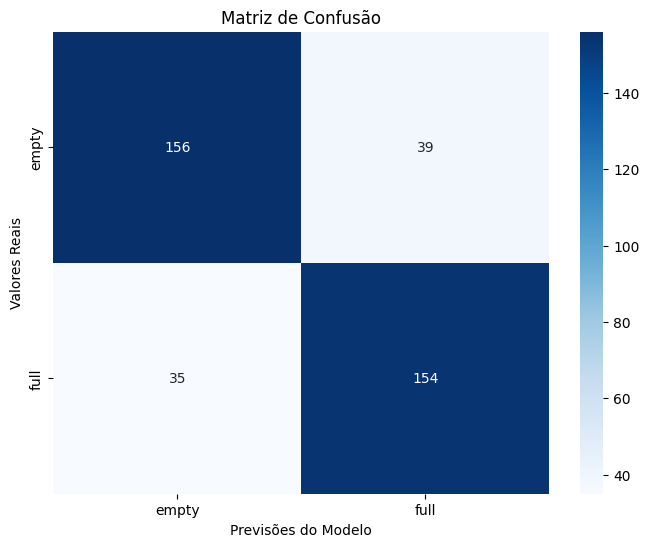


--- Resultados Detalhados ---
Verdadeiros Positivos (VP - Previsão 'full' correta): 154
Verdadeiros Negativos (VN - Previsão 'empty' correta): 156
Falsos Positivos (FP - Previsão 'full' incorreta): 39
Falsos Negativos (FN - Previsão 'empty' incorreta): 35


In [154]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Obtenha os rótulos verdadeiros e as previsões do modelo

y_true = []
y_pred_logits = []

# Iterar sobre o dataset de teste para obter os rótulos e as previsões
for images, labels in test_ds:
    # Coleta os rótulos reais
    y_true.extend(labels.numpy())

    # Faz a predição para o lote atual de imagens
    predictions = model.predict(images, verbose=0)
    y_pred_logits.extend(predictions)

# 2. Converte os logits em classes preditas
y_pred = np.argmax(y_pred_logits, axis=1)

# 3. Gerar a Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)

# 4. Visualizar a Matriz de Confusão
class_names = ['empty', 'full']

plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,          # Mostra os valores na matriz
            fmt='d',             # Formato dos números (inteiro)
            cmap='Blues',        # Mapa de cores
            xticklabels=class_names,  # Rótulos do eixo X (Previsões)
            yticklabels=class_names)  # Rótulos do eixo Y (Valores Reais)

plt.xlabel('Previsões do Modelo')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.show()

# 5. Interpretar a Matriz de Confusão
tn, fp, fn, tp = cm.ravel()

print("\n--- Resultados Detalhados ---")
print(f"Verdadeiros Positivos (VP - Previsão 'full' correta): {tp}")
print(f"Verdadeiros Negativos (VN - Previsão 'empty' correta): {tn}")
print(f"Falsos Positivos (FP - Previsão 'full' incorreta): {fp}")
print(f"Falsos Negativos (FN - Previsão 'empty' incorreta): {fn}")